# **Titanic: Machine learning from disaster**


## Introdução

Em 15 de abril de 1912 após colidir com um iceberg o navio mais moderno da época, o Titanic, veio a naufragar **matando 1502 pessoas de um total de 2224 passageiros.** O motivo de morrer tanta gente? Não havia botes salva-vidas o suficiente para todos na hora do desastre!

Obviamente, aqueles que sobreviveram à tragédia contaram com muita sorte, mas será que alguns grupos de passageiros não tiveram "mais sorte" que outros grupos? Será que crianças e mulheres realmente tiveram mais chances de sobreviver? Será que o Jack teve menos chances de escapar do seu destino trágico que a Rose, só pelo fato de ele ter embarcado na 3ª Classe?

O desafio do Titanic é uma das competições mais famosas no mundo da ciência de dados e é promovida pelo Kaggle.

![Titanic](https://aventurasnahistoria.uol.com.br/media/_versions/naufragio/titaniammd_widelg.jpg)

## Objetivo

* Analisar quais variáveis tiveram mais influência na probabilidade de sobrevivência dos tripulantes;
* Construir um modelo que dê a previsão de sobrevivência de um passageiro X.

## Métrica para validação do modelo

O score é calculado em relação ao número de previsões corretas que seu modelo fez. Ou seja, é considerada apenas a **acurácia** do modelo.

---------------------------------------------------------------------------------------------------------------------------------------------

## Importando as bibliotecas e os dados

In [1]:
!pip install -U lightautoml

     |████████████████████████████████| 252 kB 397 kB/s 
     |████████████████████████████████| 204 kB 3.2 MB/s 
     |████████████████████████████████| 2.5 MB 4.6 MB/s 
     |████████████████████████████████| 424 kB 11.6 MB/s 
     |████████████████████████████████| 232 kB 13.1 MB/s 
     |████████████████████████████████| 3.3 MB 11.5 MB/s 
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7596 sha256=cf8edd693290b7851778bfad459041530b30bccde58cb700c2556158c98577c3
  Stored in directory: /root/.cache/pip/wheels/e5/99/37/e1839a5ad733e0d6abb7e0419fd913e8926ddf96408239ce01
  Created wheel for log-calls: filename=log_calls-0.3.2-py3-none-any.whl size=51827 sha256=4551217956cf9b8d8cf85c18436c65e60651b0654b79aead53fb809747ec12e1
  Stored in directory: /root/.cache/pip/wheels/4c/4b/a5/a5643cfdcff002bbaf88cff0e52326db94182507613b53e971
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=3793201d34904ddc0

In [2]:
# Importando as bibliotecas

# Análise de dados
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Split e validação
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import f1_score, accuracy_score

# Modelos
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [3]:
# Importando os dados
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

## Análise exploratória e definições das variáveis

Nesta sessão vamos explorar os dados para saber se há dados nulos que possam atrapalhar o modelo aprender os padrões e fazer uma análise descritiva de cada variável.

In [4]:
# Para saber se há alguma variável nula no dataset
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

As variáveis **Age** e **Cabin** são as únicas com dados nulos, iremos tratá-los mais adiante.

In [5]:
# Informações gerais
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


É importante saber o nome das colunas assim como os tipos de dados e a contagem total de não-nulos. Como os algoritmos trabalham com dados do tipo **inteiro** (números) ou **float** (números quebrados), as colunas do tipo **object** devem ser mudadas.

In [6]:
# Dando uma olhada nas primeiras linhas do dataset
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Dicionário de Dados

* **PassengerId:** Número de identificação do passageiro
* **Survived:** Informa se o passageiro sobreviveu ao desastre 
    *  0 = Não
    *  1 = Sim
* **Pclass:** Classe do bilhete
   *  1 = 1ª Classe
   *  2 = 2ª Classe
   *  3 = 3ª Classe
* **Name:** Nome do passageiro
* **Sex:** Sexo do passageiro
* **Age:** Idade do passageiro
* **SibSp:** Quantidade de cônjuges e irmãos a bordo
* **Parch:** Quantidade de pais e filhos a bordo
* **Ticket:** Número da passagem
* **Fare:** Preço da Passagem
* **Cabin:** Número da cabine do passageiro
* **Embarked:** Porto no qual o passageiro embarcou
   *  C = Cherbourg
   *  Q = Queenstown
   *  S = Southampton

**Pouca gente sabe que o método df.describe() pode ser usado também para ver algo sobre a estatística descritiva em colunas que não são números. Para isso, é só passar o argumento include=['O'].**

In [7]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Laroche, Mrs. Joseph (Juliette Marie Louise La...",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


In [8]:
train['Cabin'].isnull().sum()

687

In [9]:
train['Age'].isnull().sum()

177

In [10]:
# Saber quantos numeros tem de cada sexo
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

Saber quantos números tem de cada sexo é importante pois na época sabemos quem tinha prioridade para resgate eram crianças e mulheres, em outras palavras, os homens foram a maioria que morreram.

Nos dados de treino o total de passageiros do sexo masculino é **577** e o total do sexo feminino é **314**.

### Explorando alguns gráficos para entender a importância das variáveis na sobrevivência

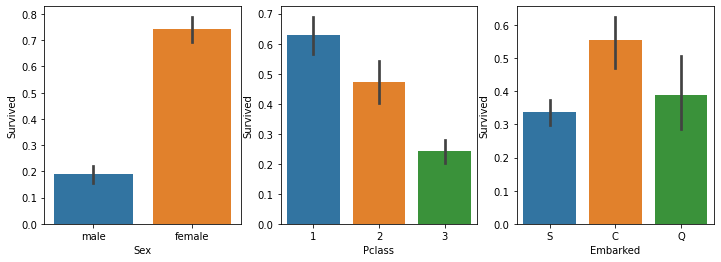

In [11]:
# Plotando os gráficos para Survived vs. Sex, Pclass e Embarked
fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize=(12,4))

sns.barplot(x='Sex', y='Survived', data=train, ax=axis1)
sns.barplot(x='Pclass', y='Survived', data=train, ax=axis2)
sns.barplot(x='Embarked', y='Survived', data=train, ax=axis3);

Nos gráficos acima, cruzei os dados dos tripulantes que sobreviveram com as colunas Sexo, Classe do bilhete e o porto no qual foi embarcado.

**Vemos que a maioria é do sexo feminino da 1ª classe e que embarcou em Cherbourg.**

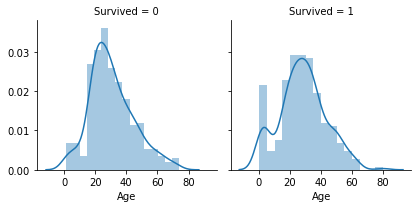

In [12]:
# Observando a influência da idade na probabilidade de sobrevivência
age_survived = sns.FacetGrid(train, col='Survived')
age_survived.map(sns.distplot, 'Age')

A idade da maioria de quem sobreviveu foi entre 20 a 40 anos.

Já a idade de quem não sobreviveu foi entre 20 e 30 anos.

Em suma, homens crianças e homens velhos teve maior influcência na sobrevivência do que os mais adultos.

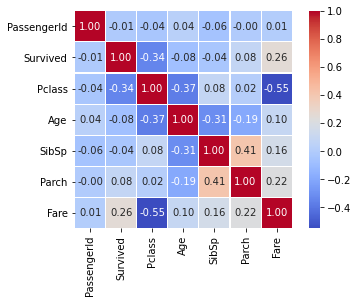

In [13]:
# Plotando o heatmap para as variáveis numéricas
sns.heatmap(train.corr(), cmap='coolwarm', fmt='.2f', linewidths=0.1,
            vmax=1.0, square=True, linecolor='white', annot=True);

Esse é um dos gráficos mais importantes de uma análise exploratória dos dados pois ele mostra a correlação entre as variáveis para compreender algum padrão.

## **Podemos observar que:**

 - Na coluna Name tem títulos diferentes para ambos os sexos como Mr. ou Miss, etc;
 - A coluna PClass tem uma significante relação com a sobrevivência dos passgeiros;
 - Na coluna Embarked há três lugares distintos únicos para embarque de passageiros;
 - Nas colunas Cabin e Age contém variáveis nulas (não preenchidas);
 - Na coluna Sex, as variáveis são nominais (strings);
 
**Levando em consideração essas observações, é necessário transformar os dados para melhorar a performance do algoritmo.**

### Tratando a coluna Sex

Como mensionado anteriormente, o algoritmo só aprende com números, então criei esta função para transformar as duas únicas strings da variável **Sex** (Male e Female) em binário:

* Retorna 1 para feminino
* Retorna 0 para masculino

In [14]:
# Vamos transformar as variáveis male e female em binários (como só possuem dois tipos) - transformando de string para int
def transformar_sexo(valor):
    if valor == 'female':
        return 1
    else: 
        return 0

In [15]:
# Transformando cada linha do Sex em binario
train['Sex_binario'] = train['Sex'].map(transformar_sexo)

### Tratando a coluna Age

Neste caso, vou substituir os dados nulos pela média das idades (geralmente é o melhor método)

In [16]:
# Descobrindo a média
media = train['Age'].mean()

# Arredondando a idade
media = math.floor(media)

print(f'A media de idade é de {media} anos')

# Atualizando os dados nulos pela média
train.update(train['Age'].fillna(media))

A media de idade é de 29 anos


### Tratando a coluna Pclass

Esta coluna indica o tipo de classe que o passageiro estava, podendo ser da 1ª classe, 2ª ou 3ª.
Vamos criar para cada tipo uma coluna própria.

In [17]:
# Tipos de classe
train['Pclass_1'] = (train['Pclass'] == '1').astype(int)
train['Pclass_2'] = (train['Pclass'] == '2').astype(int)
train['Pclass_3'] = (train['Pclass'] == '3').astype(int)

### Tratando a coluna Embarked

Outra coluna que se mostrou correlata com a sobrevivência foi o Embarked, faremos a mesma coisa que foi feito com a coluna Pclass.

In [18]:
# Possíveis locais de embarque
train['Embarked_S'] = (train['Embarked'] == 'S').astype(int)
train['Embarked_C'] = (train['Embarked'] == 'C').astype(int)
train['Embarked_Q'] = (train['Embarked'] == 'Q').astype(int)

### Tratando as cabines nulas

Não gosto de utilizar o dropna() pois se perde muitos dados, então substituirei os dados faltantes por -1 para não impactar tanto no resultado.

In [19]:
# Cabines nulas
train['Cabin'].fillna(-1) 

0        -1
1       C85
2        -1
3      C123
4        -1
       ... 
886      -1
887     B42
888      -1
889    C148
890      -1
Name: Cabin, Length: 891, dtype: object

### Tratando a coluna Name, separando por títulos

E por fim separar os nomes pelos títulos.

In [20]:
# Mulheres solteiras e casadas
train['Nome_contem_Miss'] = train['Name'].str.contains("Miss").astype(int)
train['Nome_contem_Mrs'] = train['Name'].str.contains("Mrs").astype(int)

# Patentes dos homens
train['Nome_contem_Master'] = train['Name'].str.contains("Master").astype(int)
train['Nome_contem_Mr'] = train['Name'].str.contains("Mr").astype(int)
train['Nome_contem_Col'] = train['Name'].str.contains("Col").astype(int)
train['Nome_contem_Major'] = train['Name'].str.contains("Major").astype(int)

### Verificando como ficou o dataset

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_3,Embarked_S,Embarked_C,Embarked_Q,Nome_contem_Miss,Nome_contem_Mrs,Nome_contem_Master,Nome_contem_Mr,Nome_contem_Col,Nome_contem_Major
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,0,0,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,1,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,0,0,1,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,1,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,0,0,0,0,1,0,0


## Split e Validação

Após a modelagem dos dados, agora devemos fazer o split dos dados e validar o modelo.

Nesta sessão vamos separar os dados de treino para usar uma parte para treinar o modelo e a outra parte como validação antes de usar os dados de teste.

In [22]:
# Split para o treino e validação
np.random.seed(42)
df_train, df_valid = train_test_split(train, test_size=0.2, stratify=train['Survived'])

## Utilizando o LightAutoML - automatic model creation framework

Nesta versão eu decidi utilizar o AutoML para encontrar o melhor algoritmo de classificação para o desafio, neste caso iremos avaliar qual tiver a maior acurácia.

O framework do LightAutoML é usado para problemas envolvendo classificação binária ou multiclasses e regressões, e em comparação com outros frameworks ele têm se mostrado um dos mais rápidos e precisos.

### Validação com F1_score

Utilizaremos a métrica f1_score para prestar mais atenção no balanceamento do Precision/Recall do modelo ao invés de apenas medir a acurácia.

In [23]:
def f1_metric(y_true, y_pred):
    return f1_score(y_true, (y_pred > 0.5).astype(int))

In [24]:
# Especificando o modelo para classificação binária com a métrica do f1
task = Task('binary', metric = f1_metric)

In [25]:
%%time
# Determinando a coluna alvo e se quiser excluir alguma coluna é só colocar na lista do drop

roles = {'target': 'Survived',
         'drop': ['PassengerId']}

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [26]:
# Determinando os parâmetros do modelo inicial
automl = TabularAutoML(task = task, 
                       timeout = 600, # 600 seconds = 10 minutes
                       cpu_limit = 4, # Optimal for Kaggle kernels
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]})

### Alguns algoritmos que podem ser passados no parâmetros "general_params":
   - 'linear_12'= Linear model
   - 'lgb'= LightGBM com parâmetros baseados no dataset
   - 'lgb_tuned' = LightGBM com parâmetros tunados utilizando o Optuna
   - 'cb' = CatBoost
   - 'cb_tuned' = CatBoost com hyperparâmetros

In [27]:
# oof= Out_of_fold, um termo da validação cruzada 'k-fold' um tipo de out_of_sample usado no treinamento de partes de um modelo.
oof_pred = automl.fit_predict(df_train, roles = roles)

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 600 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (712, 25)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 581.7213234901428 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.0
Linear model: C = 5e-05 score = 0.0
Linear model: C = 0.0001 score = 0.0

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.0
Linear model: C = 5e-05 score = 0.0
Linear model: C = 0.0001 score = 0.03571428571428572
Linear model: C = 0.0005 score = 0.6813186813186813
Linear model: C = 0.001 score = 0.7010309278350516
Linear model: C = 0.005 score = 0.7326732673267325
Linear model: C = 0.01 score = 0.7572815533980584
Linear model: C = 0.05 score = 0.7184466019417476
Linear model: C = 0.1 score = 0.737864077669903

===== Start working with fo

In [28]:
# Usando os dados de validação no predict
valid_pred = automl.predict(df_valid)

In [29]:
# Criando uma função para verificar a acurácia do modelo treinado
def acc_score(y_valid, y_pred):
    return accuracy_score(y_valid, (y_pred > 0.5).astype(int))

In [30]:
treino = acc_score(df_train['Survived'].values, oof_pred.data[:, 0])
valid = acc_score(df_valid['Survived'].values, valid_pred.data[:, 0])

print(f'Acurácia do treino: {treino}')
print(f'Acurácia da validação: {valid}')

Acurácia do treino: 0.8469101123595506
Acurácia da validação: 0.7988826815642458


A Acurácia final foi de 84% para o treino e 79% para a validação, mas podemos melhorar ainda.

## Melhorando o algoritmo utilizando o TabularUtilizedAutoML e retreinando o modelo

In [31]:
automl = TabularUtilizedAutoML(task = task, 
                       timeout = 600, # 600 seconds = 10 minutes
                       cpu_limit = 4, # Optimal for Kaggle kernels
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]})

In [32]:
oof_pred = automl.fit_predict(df_train, roles = roles)

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 599.9956936836243 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (712, 25)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 599.2344360351562 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.0
Linear model: C = 5e-05 score = 0.0
Linear model: C = 0.0001 score = 0.0

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.0
Linear model: C = 5e-05 score = 0.0
Linear model: C = 0.0001 score = 0.03571428571428572
Linear model: C = 0.0005 score = 

In [33]:
valid_pred = automl.predict(df_valid)

In [34]:
treino = acc_score(df_train['Survived'].values, oof_pred.data[:, 0])
valid = acc_score(df_valid['Survived'].values, valid_pred.data[:, 0])

print(f'Acurácia do treino: {treino}')
print(f'Acurácia da validação: {valid}')

Acurácia do treino: 0.8539325842696629
Acurácia da validação: 0.8156424581005587


Agora vemos um aumento da acurácia do modelo tanto do treino quanto da validação, sendo **85%** e **81%**!

## Aplicando ao teste

### Modelagem dos dados:

In [35]:
# Transformando o sexo em binário
test['Sex_binario'] = test['Sex'].map(transformar_sexo)

# Media da idade
media_t = train['Age'].mean()
media_t = math.floor(media)
test.update(test['Age'].fillna(media_t))

# Classes
test['Pclass_1'] = (test['Pclass'] == '1').astype(int)
test['Pclass_2'] = (test['Pclass'] == '2').astype(int)
test['Pclass_3'] = (test['Pclass'] == '3').astype(int)

# Possíveis locais de embarque
test['Embarked_S'] = (test['Embarked'] == 'S').astype(int)
test['Embarked_C'] = (test['Embarked'] == 'C').astype(int)
test['Embarked_Q'] = (test['Embarked'] == 'Q').astype(int)

# Cabines nulas
test['Cabin'].fillna(-1) 

# Patentes
test['Nome_contem_Miss'] = test['Name'].str.contains("Miss").astype(int)
test['Nome_contem_Mrs'] = test['Name'].str.contains("Mrs").astype(int)
test['Nome_contem_Master'] = test['Name'].str.contains("Master").astype(int)
test['Nome_contem_Mr'] = test['Name'].str.contains("Mr").astype(int)
test['Nome_contem_Col'] = test['Name'].str.contains("Col").astype(int)
test['Nome_contem_Major'] = test['Name'].str.contains("Major").astype(int)

### Passando os dados do teste no modelo:

In [36]:
automl = TabularUtilizedAutoML(task = task, 
                       timeout = 600, # 600 seconds = 10 minutes
                       cpu_limit = 4, # Optimal for Kaggle kernels
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]})

oof_pred = automl.fit_predict(train, roles = roles)
test_pred = automl.predict(test)

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 599.996169090271 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (891, 25)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 599.1761538982391 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.0
Linear model: C = 5e-05 score = 0.0
Linear model: C = 0.0001 score = 0.372093023255814
Linear model: C = 0.0005 score = 0.7286821705426356
Linear model: C = 0.001 score = 0.7480916030534351
Linear model: C = 0.005 score = 0.7703703703703704
Linear model: C = 0.01 score = 0.7703703703703704
Linear model:

## Submissão do resultado

E por fim criaremos um arquivo "modelo_final.csv" com as previsões do modelo e faremos a submissão no desafio. 

Obs: Deve ser exatamente igual o arquivo "gender_submission.csv"

In [37]:
submission = pd.read_csv('../input/titanic/gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Concatenando o resultado no dataset submission e criando um novo arquivo.

In [38]:
submission['Survived'] = (test_pred.data[:, 0] > 0.5).astype(int)
submission.to_csv('modelo_final.csv', index = False)

In [39]:
# Confirmando os dados do arquivo
!head -n10 modelo_final.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
